In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import sklearn
from scipy.sparse import csr_matrix
import copy


In [3]:
adata = sc.read_h5ad("/home/jovyan/work/Research_datasets/PBMC_Hao/GSE164378_Hao/Batch_corrected/test_harmony_no_cpm.h5ad")
adata.shape  # row is cells, column is gene

(161764, 33538)

In [4]:
type(adata.X)

scipy.sparse._csc.csc_matrix

In [5]:
# view adata.X
rows, cols = adata.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata.X[row, col]}')
    i += 1


Row 0, Column 12, Value 0.6931471824645996
Row 0, Column 43, Value 1.0986123085021973
Row 0, Column 48, Value 1.0986123085021973
Row 0, Column 53, Value 1.0986123085021973
Row 0, Column 55, Value 1.7917594909667969
Row 0, Column 66, Value 0.6931471824645996
Row 0, Column 77, Value 1.0986123085021973
Row 0, Column 78, Value 1.7917594909667969
Row 0, Column 89, Value 1.0986123085021973
Row 0, Column 93, Value 1.3862943649291992
Row 0, Column 102, Value 1.0986123085021973
Row 0, Column 154, Value 2.890371799468994
Row 0, Column 178, Value 1.0986123085021973
Row 0, Column 185, Value 0.6931471824645996
Row 0, Column 190, Value 0.6931471824645996
Row 0, Column 201, Value 2.1972246170043945
Row 0, Column 224, Value 1.0986123085021973
Row 0, Column 240, Value 0.6931471824645996
Row 0, Column 259, Value 0.6931471824645996
Row 0, Column 261, Value 1.9459102153778076


In [6]:
# assuming data.X is your sparse CSR matrix
num_nonzero = adata.X.getnnz(axis=1)  # number of nonzeros for each row
num_nonzero[:10]

array([2915, 1617, 1381, 1890, 1621, 1633, 2672, 1122, 1375, 1200])

In [7]:
# All level 1 celltypes
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(" ", "_")
adata.obs['celltype.l2'] = adata.obs['celltype.l2'].str.replace(" ", "_")
adata.obs['celltype.l3'] = adata.obs['celltype.l3'].str.replace(" ", "_")
types = np.unique(adata.obs['celltype.l1']).tolist()
print(types)
# cell count in each celltype
adata.obs['celltype.l1'].value_counts()

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


Mono       49010
CD4_T      41001
CD8_T      25469
NK         18664
B          13800
other_T     6789
DC          3589
other       3442
Name: celltype.l1, dtype: int64

In [8]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,0
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,3
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,7
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,1
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,7


## UMAP with stored embedding in Hao_PBMC_scaled_Harmony.h5ad

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


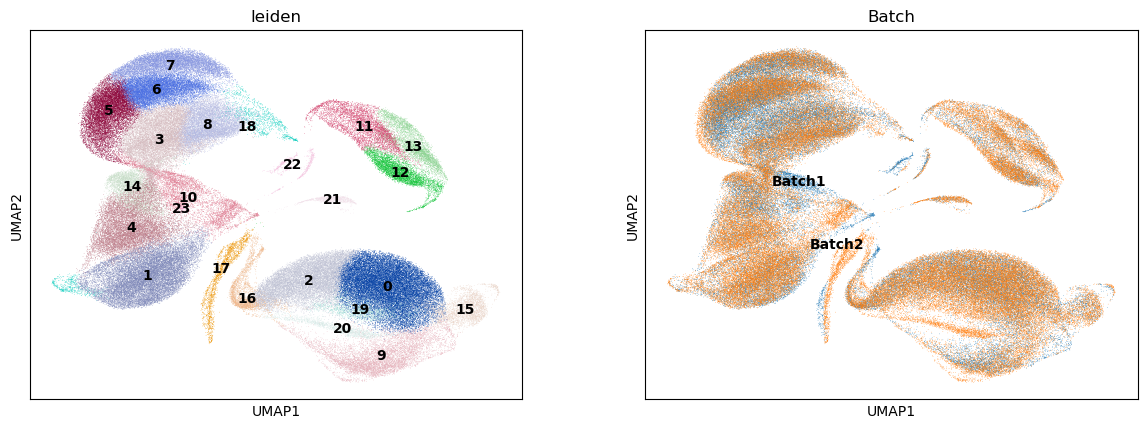

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


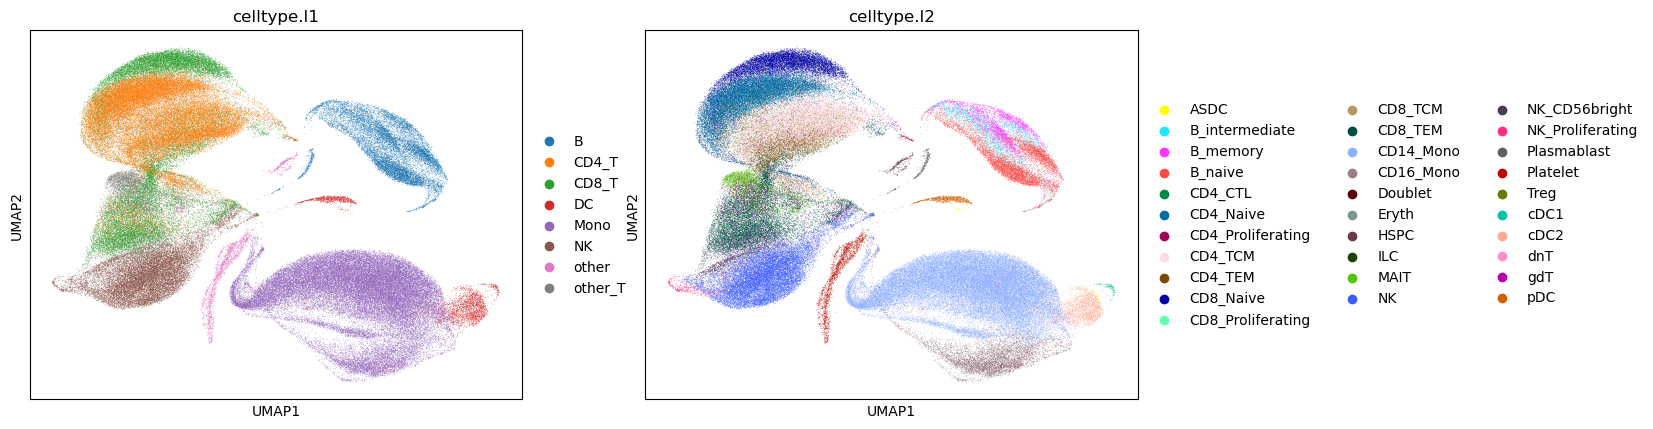

In [9]:
sc.pl.umap(adata, color=['leiden', 'Batch'], legend_loc="on data")
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2'], legend_loc="right margin")

## Representative cells
Select top clustering coefficient cells in each cell type <br>
According to the inverse relationshiop between "celltype cell count" and "Percentage" <br>
Detailed in Excel file <br>

In [10]:
umap_adja_matrix = adata.obsp['connectivities']
umap_adja_matrix

<161764x161764 sparse matrix of type '<class 'numpy.float32'>'
	with 3665352 stored elements in Compressed Sparse Row format>

In [11]:
# Clustering coefficient
import networkx as nx

G = nx.from_scipy_sparse_array(umap_adja_matrix)
print(G)

clustering_coeff = nx.clustering(G)
print(len(clustering_coeff))

Graph with 161764 nodes and 1832676 edges
161764


In [12]:
# Get the first 10 keys and values of the dictionary
first_10_items = list(clustering_coeff.items())[:10]

# Print the first 10 keys and values
for key, value in first_10_items:
    print(f"Key: {key}, Value: {value}")

# Keys are cell index, values are the corresponding clustering coefficient

Key: 0, Value: 0.14285714285714285
Key: 1, Value: 0.20476190476190476
Key: 2, Value: 0.08143939393939394
Key: 3, Value: 0.1619047619047619
Key: 4, Value: 0.10144927536231885
Key: 5, Value: 0.15268817204301074
Key: 6, Value: 0.17666666666666667
Key: 7, Value: 0.19523809523809524
Key: 8, Value: 0.13763440860215054
Key: 9, Value: 0.2916666666666667


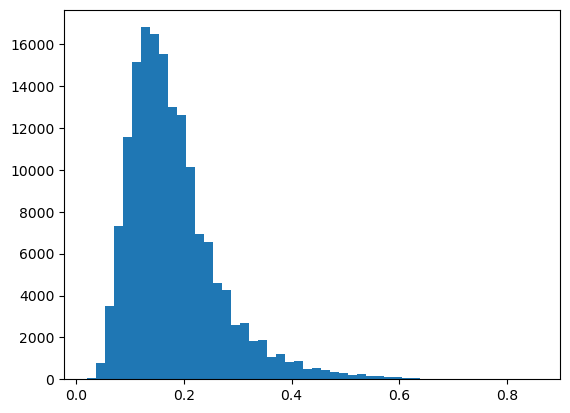

In [13]:
# Plot the distribution of clustering coefficients
import matplotlib.pyplot as plt
coefs = list(clustering_coeff.values())
plt.hist(coefs, bins=50)
plt.show()


In [14]:
# selection criteria
inv_percentage = pd.read_csv('L1_inverse_percentage.csv', index_col=0)
inv_percentage

,Original count,Percentage,Count
Mono,49010,0.200000,9802.000000
CD4_T,41001,0.340607,13965.245800
CD8_T,25469,0.613290,15619.883730
NK,18664,0.732760,13676.229490
B,13800,0.818153,11290.512640
other_T,6789,0.941239,6390.074737
DC,3589,0.997419,3579.737658
other,3442,1.000000,3442.000000


In [15]:
# Select top 20% clustering coefficient cells in each cell type
alltype_selected = dict()

for celltype in types:
    print('====================')
    print(celltype)
    # get percentage
    percentage = inv_percentage.loc[celltype, 'Percentage']
    print(celltype, percentage)

    # select cells from one celltype
    celltype_idx = np.where(adata.obs['celltype.l1'] == celltype)[0]
    celltype_coeff = {node_idx: clustering_coeff[node_idx] for node_idx in celltype_idx}
    
    top_count = int(len(celltype_coeff) * percentage)
    print('top count', top_count)
    top_indices = sorted(celltype_coeff, key=celltype_coeff.get, reverse=True)[:top_count]  # sort celltype_coeff by value (descending)
    # print(top_indices)
    celltype_selected = {node_idx: celltype_coeff[node_idx] for node_idx in top_indices}
    # print(celltype_selected)
    alltype_selected.update(celltype_selected)
    print(celltype, len(celltype_selected))


B
B 0.81815309
top count 11290
B 11290
CD4_T
CD4_T 0.340607444
top count 13965
CD4_T 13965
CD8_T
CD8_T 0.613290028
top count 15619
CD8_T 15619
DC
DC 0.997419242
top count 3579
DC 3579
Mono
Mono 0.2
top count 9802
Mono 9802
NK
NK 0.732759831
top count 13676
NK 13676
other
other 1.0
top count 3442
other 3442
other_T
other_T 0.941239466
top count 6390
other_T 6390


In [16]:
len(alltype_selected)

77763

In [17]:
# add column to adata.obs
is_representative = ['Yes' if cell in alltype_selected.keys() else 'No' for cell in clustering_coeff.keys()]
is_representative = np.array(is_representative)

# Add is_representative (Yes or No) to data.obs
adata.obs['is_representative'] = is_representative
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,0,No
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,3,Yes
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,7,No
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,1,Yes
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,7,No


In [18]:
sum(adata.obs['is_representative'] == 'Yes')

77763

In [19]:
# Add a column: Cluster_representative
# 在 representative cell 中，加上 cluster
clus_rep = []
for i in range(adata.shape[0]):
    if adata.obs['is_representative'][i] == 'Yes':
        # Yes_cluster_name
        clus_rep.append(adata.obs['is_representative'][i] + '_' + adata.obs['celltype.l1'][i])
    else:
        # No
        clus_rep.append(adata.obs['is_representative'][i])

adata.obs['cluster_representative'] = clus_rep

In [20]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative,cluster_representative
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,0,No,No
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,3,Yes,Yes_CD4_T
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,7,No,No
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,1,Yes,Yes_NK
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,7,No,No


## Plot representative cell UMAP

In [21]:
### Get palette
# Get cell counts for each cell type
l1_cell_counts = adata.obs['celltype.l1'].value_counts()  # in value order 
l2_cell_counts = adata.obs['celltype.l2'].value_counts()

# Get colors from sc.pl.umap() plot
l1_colors = adata.uns['celltype.l1_colors']  # in celltype alphabet order
l2_colors = adata.uns['celltype.l2_colors']
# map cell type names to colors
l1_cmap = dict(zip(l1_cell_counts.index.sort_values(), l1_colors))  # in alphabet order
l2_cmap = dict(zip(l2_cell_counts.index.sort_values(), l2_colors))

In [22]:
l1_cmap

{'B': '#1f77b4',
 'CD4_T': '#ff7f0e',
 'CD8_T': '#2ca02c',
 'DC': '#d62728',
 'Mono': '#9467bd',
 'NK': '#8c564b',
 'other': '#e377c2',
 'other_T': '#7f7f7f'}

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


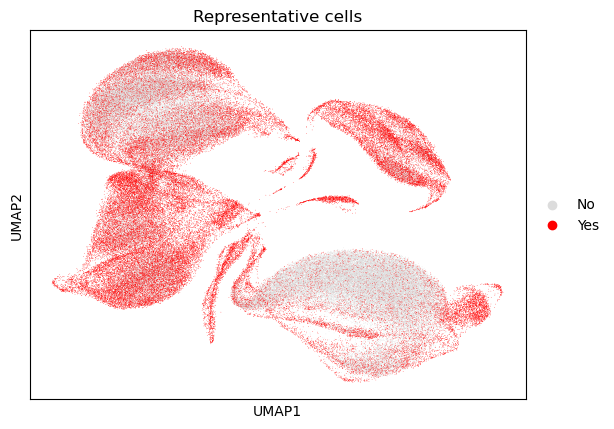

In [23]:
# Plot Yes/No representative cells
sc.pl.umap(adata, color='is_representative', title='Representative cells', palette=['#dcdcdc', 'red'])

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


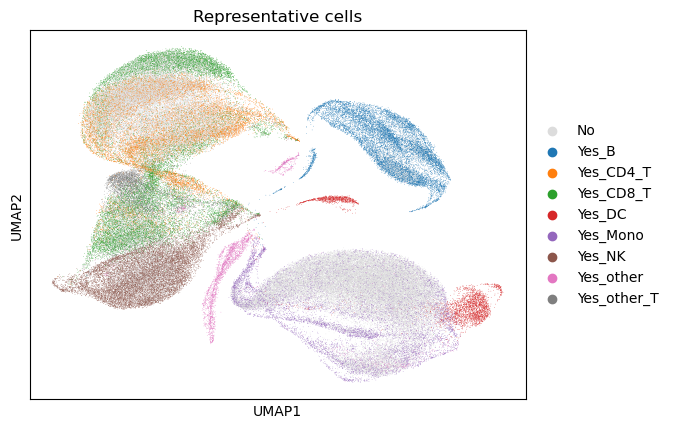

In [24]:
# Also differentiating representative cells from different cell types
sc.pl.umap(adata, color='cluster_representative', title='Representative cells', palette=['#dcdcdc']+l1_colors.tolist())  # , palette=['#dcdcdc']+l1_colors

## Export representative cells adata

In [25]:
# os.chdir(r'C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Batch_corrected')
os.chdir('/home/jovyan/work/Research_datasets/PBMC_Hao/GSE164378_Hao/Batch_corrected')

In [26]:
adata_rep_cells = adata[adata.obs['is_representative'] == 'Yes']
adata_rep_cells.shape

(77763, 33538)

In [27]:
adata_rep_cells.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative,cluster_representative
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,3,Yes,Yes_CD4_T
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,1,Yes,Yes_NK
L1_AAACCCACATCAGTCA,CD8_T,CD8_TEM,CD8_TEM_1,Batch1,P3,2,L1,G1,5297,212,4332,1633,4,Yes,Yes_CD8_T
L1_AAACCCACATGGATCT,B,B_intermediate,B_intermediate_lambda,Batch1,P4,2,L1,G1,8210,222,3589,1122,13,Yes,Yes_B
L1_AAACCCAGTGGAACAC,NK,NK,NK_2,Batch1,P1,2,L1,G2M,2847,201,3251,1375,1,Yes,Yes_NK


In [28]:
adata_rep_cells.write_h5ad('test_L1rep.h5ad')

In [29]:
np.unique(adata_rep_cells.obs['celltype.l1']).tolist()

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']